# Fine-tuning custom embedding models on synthetic data

Bootstrapping and maintaining production-ready RAG pipelines, requires optimising various components like the LLM, vector database, embeddings and rerankers. Within this notbeook we will showcase how you can optimize and maintain your embedding models through synthetic data and human feedback. Besides ZenML, we will do this by using two open source libraries: `argilla` and `distilabel`. Both of these libraries focus optimizing model outputs through improving data quality, however, each one of them take a diferent approach to tackle the same problem. `distilabel` provides a scalable and reliable approach to distilling knowledge from LLMs by generating synthetic data or providing AI feedback with LLMs as judges. `argilla` enables AI engineers and domain experts to collaborate on data projects by allowing them to organize and explore data through within an interactive and engagig UI. Both libraries can be used individually but they work better together.

- ⚗️ distilabel is a framework for synthetic data and AI feedback - [docs](distilabel.argilla.io)
- Argilla is a collaboration tool for AI engineers and domain experts to build high-quality datasets - [docs](docs.argilla.io)

## The dataset - vibe check

Before starting any project, it is always important to look at your data. Our data is publicly [available on the Hugging Face Hub](https://huggingface.co/datasets/zenml/rag_qa_embedding_questions_0_60_0) so we can have a quick look through [their dataset viewer within an embedded iFrame](https://huggingface.co/docs/hub/datasets-viewer-embed). 

As we can see, our dataset contains a column called `page_content`, which was
obtained from the ZenML docs. (To read a full explanation for how this dataset
was generated, please refer to [the RAG pipeline section of our LLMOps
Guide](https://docs.zenml.io/v/docs/user-guide/llmops-guide/rag-with-zenml).)

<iframe src="https://huggingface.co/datasets/zenml/rag_qa_embedding_questions_0_60_0/embed/viewer" frameborder="0" width="100%" height="560px"></iframe>

Alternatively, we can load the entire dataset to disk with `datasets.load_dataset`.

In [ ]:
from datasets import load_dataset

repo_name = "zenml/rag_qa_embedding_questions_0_60_0"

dataset = load_dataset(repo_name)

dataset

## Generate synthetic query generation with `distilabel`

The [`GenerateSentencePair`](https://distilabel.argilla.io/latest/components-gallery/tasks/generatesentencepair/) component from `distilabel` that can be used to generate training datasets for embeddings models. It is a pre-defined `Task` that given an `anchor` sentence generates a `positive` sentence related to the anchor. We will also generate unrelated `negative` sentences by passing `triplet=True` and we will also provide a `context` to guide the LLM towards more specific behavior. 

Additionally, we will use the [`OpenAILLM`](https://distilabel.argilla.io/latest/components-gallery/llms/openaillm/) with `gpt4o` and [`LoadDataFromHub`](https://distilabel.argilla.io/latest/components-gallery/steps/loaddatafromhub/) to load [our dataset](https://huggingface.co/datasets/zenml/rag_qa_embedding_questions_0_60_0).

In our case, we will use the `page_content` column from our dataset as `anchor` to generate `positive` and `negatives` sentences that function as training data for the embedding model.

Now, let's capture this logic in a `distilabel` `Pipeline`!

In [ ]:
import os

from distilabel.steps.tasks import GenerateSentencePair
from distilabel.llms import OpenAILLM
from distilabel.steps import LoadDataFromHub
from distilabel.pipeline import Pipeline

context = (
"""
The text is a chunk from technical documentation of ZenML.
ZenML is an MLOps + LLMOps framework that makes your infrastructure and workflow metadata accessible to data science teams.
Along with prose explanations, the text chunk may include code snippets and logs but these are identifiable from the surrounding backticks.
"""
)

llm = OpenAILLM(model="gpt-4o", api_key=os.getenv("OPENAI_API_KEY"))

with Pipeline(name="generate_embedding_queries") as pipeline:
    load_dataset = LoadDataFromHub(
        num_examples=15,  # uncomment this for demo purposes
        output_mappings={"page_content": "anchor"},
    )
    generate_sentence_pair = GenerateSentencePair(
        triplet=True,  # `False` to generate only positive
        action="query",
        llm=llm,
        input_batch_size=10,
        context=context,
    )

    load_dataset >> generate_sentence_pair

Next, we can execute this using `pipeline.run`. We will provide some `parameters` to specific components within our pipeline.

In [ ]:
from datasets import DatasetDict

train_distiset = pipeline.run(  #
    parameters={
        load_dataset.name: {
            "repo_id": "zenml/rag_qa_embedding_questions_0_60_0",
            "split": "train",
        },
        generate_sentence_pair.name: {
            "llm": {
                "generation_kwargs": {
                    "temperature": 0.7,
                    "max_new_tokens": 512,
                }
            }
        },
    },
    use_cache=False, # comment out for demo
)

test_distiset = pipeline.run(  #
    parameters={
        load_dataset.name: {
            "repo_id": "zenml/rag_qa_embedding_questions_0_60_0",
            "split": "test",
        },
        generate_sentence_pair.name: {
            "llm": {
                "generation_kwargs": {
                    "temperature": 0.7,
                    "max_new_tokens": 512,
                }
            }
        },
    },
    use_cache=False, # comment out for demo
)

combined_distiset = DatasetDict({
    "train": train_distiset["default"]["train"],
    "test": test_distiset["default"]["train"]
})

Let's vibe check our data again. If you are not happy with the results you can either tweak our `parameters` or optimize the `context` prompt which is passed to the LLM.

In [ ]:
from rich import print

example = combined_distiset["train"][9]
print(example)

### (Optional) Push the distiset to the Hugging Face Hub

Synthetic data generation can be expensive becuae of the reliance on LLMs, so first store our data on the Hub.

In [ ]:
combined_distiset.push_to_hub(
    repo_id="zenml/rag_qa_embedding_questions_0_60_0_distilabel",
    token=os.getenv("HUGGINGFACE_API_KEY"),
)

### (Optional) Review synthetic query generation with vibe check

Data is never as clean as it can be and this also holds for synthetically generated data, therefore, it is always good to spent some time and look at your data. We will compute similarities for embeddings of `anchor-positive`, `positive-negative` and `anchor-negative` pairs. We assume that an overlap of these similarities will cause the model to have difficulties generalizing.

Next, we will load a vector embedding model, with `sentence_transformers`. In order to load a good default model, we will use the [Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard). 

<iframe
	src="https://mteb-leaderboard.hf.space"
	frameborder="0"
	width="100%"
	height="900"
></iframe>

For now, we will [Snowflake/snowflake-arctic-embed-s](https://huggingface.co/Snowflake/snowflake-arctic-embed-s) which is a small but good performing model.

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

model_id = "Snowflake/snowflake-arctic-embed-m"  # Hugging Face model ID

model = SentenceTransformer(
    model_id, device="cuda" if torch.cuda.is_available() else "cpu"
)

First, we will load the synthetic data.

<iframe src="https://huggingface.co/datasets/zenml/rag_qa_embedding_questions_0_60_0_distilabel/embed/viewer" frameborder="0" width="100%" height="560px"></iframe>


In [39]:
from datasets import load_dataset

dataset = load_dataset("zenml/rag_qa_embedding_questions_0_60_0_distilabel")

Next, we will process the original Hugging Face dataset.

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

def get_embeddings(texts):
    vectors = model.encode(texts)
    return [vector.tolist() for vector in vectors]


def get_similarities(vector_batch_a, vector_batch_b):
    similarities = []
    for vector_a, vector_b in zip(vector_batch_a, vector_batch_b):
        similarity = cosine_similarity([vector_a], [vector_b])[0][0]
        similarities.append(similarity)
    return similarities

def format_data(batch):
    batch["anchor-vector"] = get_embeddings(batch["anchor"])
    batch["positive-vector"] = get_embeddings(batch["positive"])
    batch["negative-vector"] = get_embeddings(batch["negative"])    
    batch["similarity-positive-negative"] = get_similarities(batch["positive-vector"], batch["negative-vector"])
    batch["similarity-anchor-positive"] = get_similarities(batch["anchor-vector"], batch["positive-vector"])
    batch["similarity-anchor-negative"] = get_similarities(batch["anchor-vector"], batch["negative-vector"])
    return batch

dataset = dataset.map(format_data, batched=True, batch_size=250)

Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

Map:   0%|          | 0/414 [00:00<?, ? examples/s]

We will do another vibe-check to look at the distribution of the similarity scores and plot these outcomes using a simple function.

In [45]:
import matplotlib.pyplot as plt

def get_plot(scores, labels):
    # Plotting labelled histogram and getting counts and bin edges
    counts, bins, patches = plt.hist(scores, edgecolor='black')

    # Calculate the total number of samples
    total = len(scores)

    # Adding counts and percentages per bin
    for count, bin_edge in zip(counts, bins):
        # Calculate percentage
        percentage = (count / total) * 100
        
        # Calculate the position for placing the text
        plt.text(bin_edge, count, f'{percentage:.1f}%', va='bottom', fontsize=10)
    
    # Labelling the histogram
    plt.xlabel(labels)
    plt.ylabel("Count")
    return plt

Now, let's vibe check our data. As we can see there are some outliers with relative low overlap of the anchor and positive, and relatively high overlap between the anchor and negative.

<module 'matplotlib.pyplot' from '/Users/davidberenstein/Documents/programming/argilla/collaborations/integrations/integration-zenml/.venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

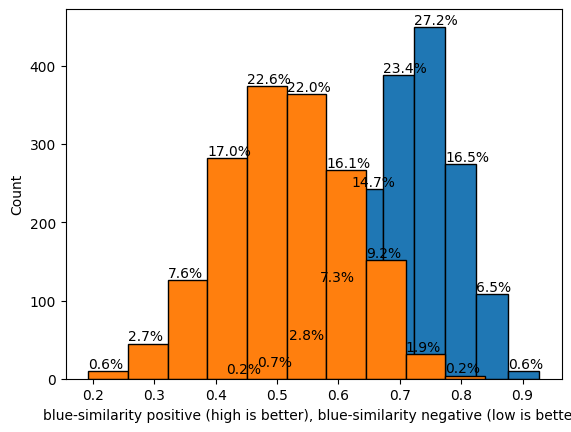

In [46]:
get_plot(dataset["train"]["similarity-anchor-positive"], "")
get_plot(dataset["train"]["similarity-anchor-negative"], "blue-similarity positive (high is better), blue-similarity negative (low is better)")

So, let's filter out the bad apples, while ensure the `similarity-positive-negative` remains as low as positive. 

In [47]:
dataset_filtered = dataset["train"]

for column, order in [
    (["similarity-anchor-positive", "similarity-positive-negative"], [True, False]), 
    (["similarity-anchor-negative", "similarity-positive-negative"], [False, False])
]:
    dataset_filtered = dataset_filtered.sort(column, reverse=order)
    n = int(len(dataset_filtered) * 0.2)
    # Filter out the first 10% of the dataset
    dataset_filtered = dataset_filtered.select(range(0, len(dataset_filtered)-n))

dataset_filtered

Dataset({
    features: ['anchor', 'parent_section', 'url', 'token_count', 'positive', 'negative', 'distilabel_metadata', 'model_name', 'anchor-vector', 'positive-vector', 'negative-vector', 'similarity-positive-negative', 'similarity-anchor-positive', 'similarity-anchor-negative'],
    num_rows: 1060
})

Next, we plot the filtered data, which seems to show a way cleaner separation within the data.

<module 'matplotlib.pyplot' from '/Users/davidberenstein/Documents/programming/argilla/collaborations/integrations/integration-zenml/.venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

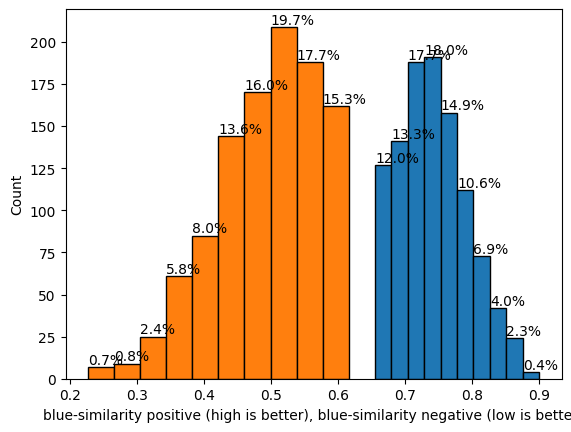

In [48]:
get_plot(dataset_filtered["similarity-anchor-positive"], "")
get_plot(dataset_filtered["similarity-anchor-negative"], "blue-similarity positive (high is better), blue-similarity negative (low is better)")

However, currently, we don't really know what we filtered out. So we need something a bit more visual.

In [102]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import umap

# Load and prepare the data
data = pd.concat([dataset["test"].to_pandas(), dataset["train"].to_pandas()], ignore_index=True)
X = data["anchor-vector"].tolist()
labels = [section if section is not None else "random" for section in data["parent_section"]]
certainty_scores = data["similarity-anchor-positive"]
similarity_anchor_negative = data["similarity-anchor-negative"]
similarity_positive_negative = data["similarity-positive-negative"]
text = [
    f'positive: {positive}<br>negative: {negative}<br>similarity-anchor-positive: {similarity_anchor_positive:.2f}<br>similarity-anchor-negative: {similarity_anchor_negative:.2f}<br>similarity-positive-negative: {similarity_positive_negative:.2f}'
    for positive, negative, similarity_anchor_positive, similarity_anchor_negative, similarity_positive_negative in zip(
        data["positive"], data["negative"], data["similarity-anchor-positive"], data["similarity-anchor-negative"], similarity_positive_negative
    )
]

# Dimensionality reduction using UMAP
umap_reducer = umap.UMAP()
X_embedded = umap_reducer.fit_transform(X)

# Create the Plotly figure
fig = go.Figure()
colors = ["red", "black", "blue", "orange", "green", "purple", "grey", "brown", "darkgreen", "yellow"]

# Add the scatter plot
for label in np.unique(labels):
    mask = np.array(labels) == label
    fig.add_trace(go.Scatter(
        x=X_embedded[mask, 0],
        y=X_embedded[mask, 1],
        mode='markers',
        marker=dict(
            size=20 * np.array(certainty_scores)[mask]**3,
            color=colors[np.where(np.unique(labels) == label)[0][0]]
        ),
        text=np.array(text)[mask],
        hovertemplate='%{text}',
        name=label,
        visible=True
    ))

# Add the sliders
slider_params = [
    ("Certainty Anchor Positive", certainty_scores, lambda x, i: x >= i/20),
    ("Similarity Anchor Negative", similarity_anchor_negative, lambda x, i: x >= i/20),
    ("Similarity Positive Negative", similarity_positive_negative, lambda x, i: x >= i/20)
]

fig.update_layout(
    sliders=[
        dict(
            active=0,
            currentvalue={"prefix": f"{name}: "},
            pad={"t": 50},
            len=0.9,
            x=0,
            y=i * -0.1,
            steps=[
                dict(
                    args=["visible", [condition(score, i) for score in var]],
                    label=f"{i/20:.2f}",
                    method="restyle"
                ) for i in range(21)
            ]
        ) for i, (name, var, condition) in enumerate(slider_params)
    ],
    title='Dimensionality Reduced Embedding with Labels and Certainty Scores',
    xaxis_title='UMAP Dimension 1',
    yaxis_title='UMAP Dimension 2',
    height=1200,
    width=1200
)

# Show the plot
fig.show()

### (Optional) Review synthetic query generation with `Argilla`

To get the most out of you data and actually look at our data, we will use Argilla. If you are not familiar with Argilla, we recommend taking a look at the [Argilla quickstart docs](https://docs.argilla.io/latest/getting_started/quickstart/). Alternatively, you can use your Hugging Face account to login to the [Argilla demo Space](https://argilla-argilla-template-space.hf.space).

To start exploring data, we first need to define an `argilla.Dataset`. We will create a basic datset with some input `TextFields` for the `anchor` and output `TextQuestions` for the `positive` and `negative` pairs. Additionally, we will use the `parent_section` and `token_count` as `MetaDataProperty`. Lastly, we will be re-using the vectors obtained from our previous step to allow for semantic search and we will add te similarity scores for some basic filtering and sorting.

First, we need to define the setting for our Argilla dataset.

In [104]:
import argilla as rg
from argilla._exceptions import ConflictError

api_key = "ohh so secret"
api_url = "https://davidberenstein1957-my-argilla.hf.space"

dataset_name = "rag_qa_embedding_questions_0_60_0_distilabel"

client = rg.Argilla(api_url=api_url, api_key=api_key)

settings = rg.Settings(
    fields=[
        rg.TextField("anchor")
    ],
    questions=[
        rg.TextQuestion("positive"),
        rg.TextQuestion("negative")
    ],
    metadata=[
        rg.TermsMetadataProperty("parent_section"),
        rg.IntegerMetadataProperty("token_count"),
        rg.FloatMetadataProperty("similarity-positive-negative"),
        rg.FloatMetadataProperty("similarity-anchor-positive"),
        rg.FloatMetadataProperty("similarity-anchor-negative"),
    ],
    vectors=[
        rg.VectorField("anchor-vector", dimensions=model.get_sentence_embedding_dimension())
    ]
)

ds = rg.Dataset(
    name=dataset_name,
    settings=settings
)

try:
    ds.create()
except ConflictError:
    ds = client.datasets(dataset_name)

/Users/davidberenstein/Documents/programming/argilla/collaborations/integrations/integration-zenml/.venv/lib/python3.9/site-packages/argilla/datasets/_resource.py:203: UserWarning:

Workspace not provided. Using default workspace: argilla id: fa42a580-ec9f-4364-b7ad-8213ab3e30e3



Lastly, we will log the records to Argilla.

In [105]:
records = []

for idx, entry in enumerate(dataset_filtered):
    records.append(
        rg.Record(
            id=idx,
            fields={"anchor": entry["anchor"]},
            suggestions=[
                rg.Suggestion("positive", value=entry["positive"], agent="gpt-4o", type="model"),
                rg.Suggestion("negative", value=entry["negative"], agent="gpt-4o", type="model"),
            ],
            metadata={
                "parent_section": entry["parent_section"],
                "token_count": entry["token_count"],
                "similarity-positive-negative": entry["similarity-positive-negative"],
                "similarity-anchor-positive": entry["similarity-anchor-positive"],
                "similarity-anchor-negative": entry["similarity-anchor-negative"]
            },
            vectors={"anchor-vector": entry["anchor-vector"]}
        )
    )

ds.records.log(records)

Sending records...: 5batch [00:25,  5.03s/batch]                    


DatasetRecords(Dataset(id=UUID('5d0c0900-e6f2-41aa-b669-f95d52605032') inserted_at=datetime.datetime(2024, 8, 8, 13, 47, 1, 654450) updated_at=datetime.datetime(2024, 8, 8, 13, 47, 5, 957392) name='rag_qa_embedding_questions_0_60_0_distilabel' status='ready' guidelines=None allow_extra_metadata=False distribution=OverlapTaskDistributionModel(strategy='overlap', min_submitted=1) workspace_id=UUID('fa42a580-ec9f-4364-b7ad-8213ab3e30e3') last_activity_at=datetime.datetime(2024, 8, 8, 13, 47, 5, 957392)))

Now we can explore the UI and add a final human touch to get he most out of our datset. 

## Prepare the embedding dataset

Follows [Phil Schmid's tutorial](https://www.philschmid.de/fine-tune-embedding-model-for-rag#5-evaluate-fine-tuned-model-against-baseline) fairly heavily.

In [113]:
from datasets import load_dataset

# Load dataset from the hub
dataset = load_dataset("zenml/rag_qa_embedding_questions_0_60_0_distilabel", split="train")

# Add an id column to the dataset
dataset = dataset.add_column("id", range(len(dataset)))

# split dataset into a 10% test set
dataset = dataset.train_test_split(test_size=0.1)

train_dataset_path = "../data/train_dataset.json"
test_dataset_path = "../data/test_dataset.json"

# save datasets to disk
dataset["train"].to_json(train_dataset_path, orient="records")
dataset["test"].to_json(test_dataset_path, orient="records")

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

527754

## Create baseline + evaluate pretrained model

In [119]:
import torch
from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import (
    InformationRetrievalEvaluator,
    SequentialEvaluator,
)
from sentence_transformers.util import cos_sim
from datasets import load_dataset, concatenate_datasets

model_id = "Snowflake/snowflake-arctic-embed-m"  # Hugging Face model ID
matryoshka_dimensions = [384, 256, 128, 64]  # Important: large to small

# Load a model
model = SentenceTransformer(
    model_id, device="mps"
)

# load test dataset
test_dataset = load_dataset("json", data_files=test_dataset_path, split="train")
train_dataset = load_dataset("json", data_files=train_dataset_path, split="train")
corpus_dataset = concatenate_datasets([train_dataset, test_dataset])

# Convert the datasets to dictionaries
corpus = dict(
    zip(corpus_dataset["id"], corpus_dataset["positive"])
)  # Our corpus (cid => document)
queries = dict(
    zip(test_dataset["id"], test_dataset["anchor"])
)  # Our queries (qid => question)

# Create a mapping of relevant document (1 in our case) for each query
relevant_docs = {}  # Query ID to relevant documents (qid => set([relevant_cids])
for q_id in queries:
    relevant_docs[q_id] = [q_id]


matryoshka_evaluators = []
# Iterate over the different dimensions
for dim in matryoshka_dimensions:
    ir_evaluator = InformationRetrievalEvaluator(
        queries=queries,
        corpus=corpus,
        relevant_docs=relevant_docs,
        name=f"dim_{dim}",
        truncate_dim=dim,  # Truncate the embeddings to a certain dimension
        score_functions={"cosine": cos_sim},
    )
    matryoshka_evaluators.append(ir_evaluator)

# Create a sequential evaluator
evaluator = SequentialEvaluator(matryoshka_evaluators)

Generating train split: 0 examples [00:00, ? examples/s]

In [26]:
# Evaluate the model
results = evaluator(model)

# # COMMENT IN for full results
# print(results)

# Print the main score
for dim in matryoshka_dimensions:
    key = f"dim_{dim}_cosine_ndcg@10"
    print
    print(f"{key}: {results[key]}")

dim_384_cosine_ndcg@10: 0.49027140095483185
dim_256_cosine_ndcg@10: 0.44015728920839925
dim_128_cosine_ndcg@10: 0.4258052292448508
dim_64_cosine_ndcg@10: 0.3010735610940038


## Define loss function

In [114]:
from sentence_transformers import SentenceTransformerModelCardData, SentenceTransformer

model_id = "Snowflake/snowflake-arctic-embed-m"

# load model with SDPA for using Flash Attention 2
model = SentenceTransformer(
    model_id,
    model_kwargs={"attn_implementation": "sdpa"},
    model_card_data=SentenceTransformerModelCardData(
        language="en",
        license="apache-2.0",
        model_name="BGE base Financial Matryoshka",
    ),
    device="mps"
)

In [115]:
from sentence_transformers.losses import MatryoshkaLoss, TripletLoss

matryoshka_dimensions = [384, 256, 128, 64]  # Important: large to small
inner_train_loss = TripletLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

## Finetune a model

In [122]:
from sentence_transformers import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers

# load train dataset again
train_dataset = load_dataset("json", data_files=train_dataset_path, split="train")

# define training arguments
args = SentenceTransformerTrainingArguments(
    output_dir="bge-base-financial-matryoshka",  # output directory and hugging face model ID
    num_train_epochs=4,  # number of epochs
    per_device_train_batch_size=32,  # train batch size
    gradient_accumulation_steps=16,  # for a global batch size of 512
    per_device_eval_batch_size=16,  # evaluation batch size
    warmup_ratio=0.1,  # warmup ratio
    learning_rate=2e-5,  # learning rate, 2e-5 is a good value
    lr_scheduler_type="cosine",  # use constant learning rate scheduler
    # optim="adamw_torch_fused",  # use fused adamw optimizer
    # tf32=True,  # use tf32 precision
    bf16=True,  # use bf16 precision
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    eval_strategy="epoch",  # evaluate after each epoch
    save_strategy="epoch",  # save after each epoch
    logging_steps=10,  # log every 10 steps
    save_total_limit=3,  # save only the last 3 models
    load_best_model_at_end=True,  # load the best model when training ends
    metric_for_best_model="eval_dim_128_cosine_ndcg@10",  # Optimizing for the best ndcg@10 score for the 128 dimension
)

In [123]:
from sentence_transformers import SentenceTransformerTrainer

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,  # training arguments
    train_dataset=train_dataset.select_columns(
        ["positive", "anchor", "negative"]
    ),  # training dataset
    loss=train_loss,
    evaluator=evaluator,
)

In [124]:
# start training, the model will be automatically saved to the hub and the output directory
trainer.train()

# save the best model
trainer.save_model()

# push model to hub
# trainer.model.push_to_hub("bge-base-financial-matryoshka")

  0%|          | 0/8 [00:00<?, ?it/s]

## Evaluate fine-tuned model against baseline

In [ ]:
from sentence_transformers import SentenceTransformer

fine_tuned_model = SentenceTransformer(
    args.output_dir, device="cuda" if torch.cuda.is_available() else "cpu"
)
# Evaluate the model
results = evaluator(fine_tuned_model)

# # COMMENT IN for full results
print(results)

# Print the main score
for dim in matryoshka_dimensions:
    key = f"dim_{dim}_cosine_ndcg@10"
    print(f"{key}: {results[key]}")